# Analysis of Domotopie dataset

## 1. Data importation x Data preprocessing

In [48]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import seaborn as sns
import numpy as np
import keplergl as kp
import matplotlib.pyplot as plt
sns.set() # for style
import warnings
warnings.filterwarnings("ignore")

In [49]:
# sub-sector
sous_sect = gpd.read_file('Data/geojson/sous_secteur.geojson')
sous_sect.crs="EPSG:2056"
ss=sous_sect[["SSECTEUR_7",'NOM_SSECTE','NOM_SECTEU','POP', 'geometry']]
ss=ss.to_crs(4326)
ss.head(1)

SSECTEUR_7          NOM_SSECTE             NOM_SECTEU   POP  \
0    2122050  La Petite-Boisière  Florissant - Malagnou  1172   

                                            geometry  
0  POLYGON ((6.16607 46.19628, 6.16618 46.19642, ...

In [50]:
COI=["ID","travel_time_1_min","modes_1_and_or","place_1_purpose","travel_time_2_min","modes_2_and_or","place_2_purpose","travel_time_3_min","modes_3_and_or","place_3_purpose","travel_time_4_min","modes_4_and_or","place_4_purpose","travel_time_5_min","modes_5_and_or","place_5_purpose","home_lon_centroids_ssecteur_7","home_lat_centroids_ssecteur_7","ssecteur_7","all_modes"]

In [51]:
dem=pd.read_csv("Data/action_space_clean_ssecteur7.csv")

In [52]:
dem.shape

(2283, 42)

In [53]:
dem[COI].loc[dem[COI].travel_time_2_min=="10000",:] # not really possible so it will be removed

ID travel_time_1_min modes_1_and_or place_1_purpose  \
109  121328             10000            TIM      Other home   

    travel_time_2_min modes_2_and_or place_2_purpose travel_time_3_min  \
109             10000            TIM    At relatives             10000   

    modes_3_and_or place_3_purpose travel_time_4_min modes_4_and_or  \
109            TIM    At relatives                40            TIM   

    place_4_purpose travel_time_5_min modes_5_and_or place_5_purpose  \
109    At relatives                30            TIM  At work/school   

     home_lon_centroids_ssecteur_7  home_lat_centroids_ssecteur_7  ssecteur_7  \
109                       6.155631                      46.191528   2111051.0   

    all_modes  
109       TIM

In [54]:
mode=dem[COI][["modes_1_and_or","modes_2_and_or","modes_3_and_or","modes_4_and_or","modes_5_and_or"]].unstack().values
time=dem[COI][["travel_time_1_min","travel_time_2_min","travel_time_3_min","travel_time_4_min","travel_time_5_min"]].unstack().values
ids=dem[COI][["ID"]].unstack().values
ids=np.concatenate([ids]*5)
df=pd.DataFrame([mode,time,ids]).T

In [55]:
#clean
df=df.dropna().rename({0:"mode",1:"time",2:"ID"},axis=1)
print(df.shape)
df.loc[df.time==" ",:]

(10989, 3)


mode time      ID
7       TP       114237
9       TP       136592
19      TP       104712
33      TP       138285
52      TP       108799
...    ...  ...     ...
11395   TP       101216
11396   TP       106098
11397   TP       135668
11401   TP       131050
11403   TP       148259

[1025 rows x 3 columns]

In [56]:
df=df.drop(index=df.loc[df.time==" ",:].index)
df["time"]=df["time"].astype(int)
display(df.loc[df.time>300,:])
df=df.drop(index=df.loc[df.time==0,:].index)
df=df.drop(index=df.loc[df.time>300,:].index)
print(df.shape)

mode   time      ID
95           TIM  99999  105392
109          TIM  10000  121328
211          TIM   1600  139142
290           TP  99999  103540
323           TP  99999  138253
...          ...    ...     ...
11219         TP  99999  104780
11272  MD+TP+TIM  99999  104997
11305         TP  99999  115193
11318         TP  99999  134353
11358         TP  99999  109086

[196 rows x 3 columns]

(9585, 3)


## 2.  Mode

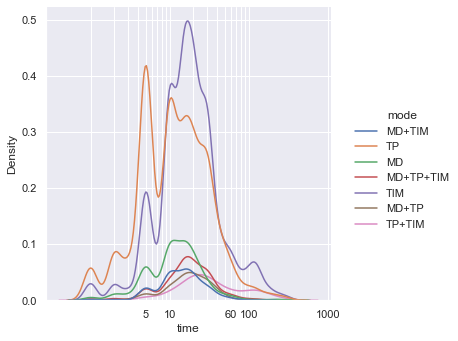

In [57]:
sns.displot(df, x="time", hue="mode", kind="kde",log_scale=True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,1000],["","","","","5","","","","","10","","","","","60","","","","100","1000"])
plt.savefig("Figures/png/all_mode.png")
plt.show()

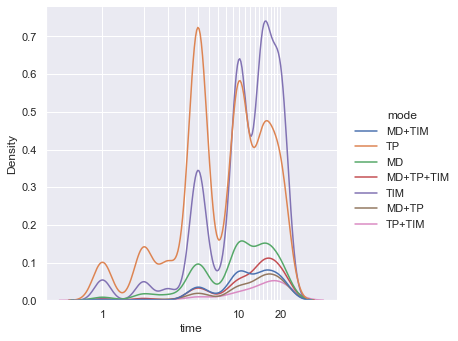

In [58]:
df_15min=df.drop(index=df.loc[df.time>20,:].index)
sns.displot(df_15min, x="time", hue="mode", kind="kde",log_scale=True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],labels=["1","","","","","","","","","10","","","","","","","","","","20"])
plt.savefig("Figures/png/15_mode.png")
plt.show()


In [59]:
df_15min.groupby(["ID","mode"]).mean()

time
ID     mode           
100007 TIM        20.0
       TP          5.0
100039 TIM         9.0
100067 TP         15.0
100073 MD+TP+TIM   5.0
...                ...
150514 TP          3.5
150557 MD+TP       7.5
999999 MD         10.0
       TIM        10.0
       TP         10.0

[3421 rows x 1 columns]

## 3.  Purpose

In [60]:
dem_purpose=dem[COI][["place_1_purpose","place_2_purpose","place_3_purpose","place_4_purpose","place_5_purpose"]].unstack().values
time=dem[COI][["travel_time_1_min","travel_time_2_min","travel_time_3_min","travel_time_4_min","travel_time_5_min"]].unstack().values
df=pd.DataFrame([dem_purpose,time]).T
#clean
df=df.dropna().rename({0:"purpose",1:"time"},axis=1)
print(df.shape)
df.loc[df.time==" ",:]
df=df.drop(index=df.loc[df.time==" ",:].index)

(11415, 2)


In [61]:
df["time"]=df["time"].astype(int)
df=df.drop(index=df.loc[df.time==0,:].index)
df=df.drop(index=df.loc[df.time>300,:].index)

In [62]:
df.groupby("purpose").mean().sort_values(by="time")


time
purpose                        
Collective transport  10.176972
Shops                 12.407492
Public services       13.198364
Individual transport  13.444444
Sport                 17.781065
Public space          17.813217
At work/school        24.388469
At relatives          26.625347
Other                 32.850299
Other home            92.352804

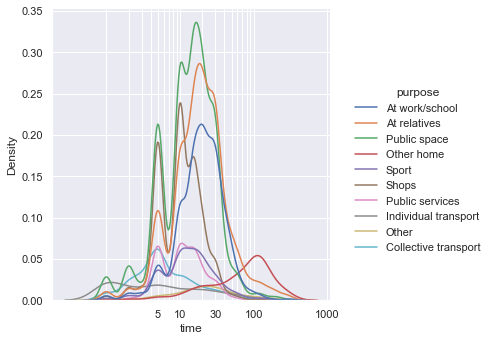

In [63]:
sns.displot(df, x="time", hue="purpose", kind="kde",palette=sns.color_palette(),log_scale=True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,1000],["","","","","5","","","","","10","","30","","","","","","","100","1000"])
plt.savefig("Figures/png/all_purpose.png")
plt.show()


In [64]:
df_15min=df.drop(index=df.loc[df.time>20,:].index)

In [65]:
df_15min.purpose.unique()

array(['At work/school', 'At relatives', 'Other home', 'Public space',
       'Sport', 'Shops', 'Public services', 'Individual transport',
       'Other', 'Collective transport'], dtype=object)

In [66]:
palette=[sns.color_palette()[0],sns.color_palette()[1],sns.color_palette()[3],sns.color_palette()[2],sns.color_palette()[4],sns.color_palette()[5],sns.color_palette()[6],sns.color_palette()[7],sns.color_palette()[8],sns.color_palette()[9]]

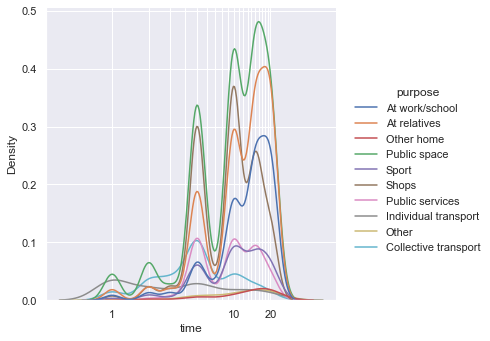

In [67]:
sns.displot(df_15min, x="time", hue="purpose", kind="kde",palette=palette,log_scale=True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],labels=["1","","","","","","","","","10","","","","","","","","","","20"])
plt.savefig("Figures/png/15_purpose.png")
plt.show()


## 4. House location ( spatial analysis )

In [68]:
df=dem[COI]
df.shape

(2283, 20)

In [69]:
df=df.drop(index=df.loc[df.travel_time_1_min==" ",:].index)
df=df.drop(index=df.loc[df.travel_time_2_min==" ",:].index)
df=df.drop(index=df.loc[df.travel_time_3_min==" ",:].index)
df=df.drop(index=df.loc[df.travel_time_4_min==" ",:].index)
df=df.drop(index=df.loc[df.travel_time_5_min==" ",:].index)
df.shape

(2027, 20)

In [70]:
df["travel_time_1_min"]=df["travel_time_1_min"].astype(float)
df["travel_time_2_min"]=df["travel_time_2_min"].astype(float)
df["travel_time_3_min"]=df["travel_time_3_min"].astype(float)
df["travel_time_4_min"]=df["travel_time_4_min"].astype(float)
df["travel_time_5_min"]=df["travel_time_5_min"].astype(float)

In [71]:
ind_to_keep=df.apply(lambda x: x.name if  x["travel_time_1_min"] < 20 and x["travel_time_2_min"] < 20 and x["travel_time_3_min"]< 20 and x["travel_time_4_min"]< 20 and x["travel_time_5_min"]< 20 else None ,axis=1)

In [72]:
ind_to_keep=ind_to_keep.dropna()

In [73]:
df_all_15=df.loc[ind_to_keep,:]

In [74]:
df_all_15.all_modes.unique()

array(['TIM', nan, 'TP', 'MD+TP+TIM', 'MD+TIM', 'TP+TIM', 'MD+TP', 'MD'],
      dtype=object)

 Hypothèse si all mode nan we base our visualisation on the most used to go into the most favorite place then if both all mode and first place are nan we manually observe the data and choose based on what is the most plausible all TP for the other destination will be set to TP and if only at relatives is multimodal we also set to TP, if it is various mode for all destination we put all mode and if all nan we put all the mode based on the hypothesis that the subject didn't know because it was changing a lot 

In [75]:
df_all_15["all_modes"][df_all_15.loc[df_all_15.all_modes.isna(),:].index]=df_all_15.loc[df_all_15.all_modes.isna(),:].modes_1_and_or

In [76]:
df_all_15.loc[df_all_15.all_modes.isna(),:].shape

(7, 20)

In [77]:
#add manually after studying the data
df_all_15["all_modes"][df_all_15.loc[df_all_15.all_modes.isna(),:].index]=["MD+TP+TIM","MD+TP+TIM","TP","TIM","TIM","TP","TP"]

In [78]:
from shapely.geometry import Point
def random_point_in_shp(shp):
    within = False
    while not within:
        x = np.random.uniform(shp.bounds[0], shp.bounds[2])
        y = np.random.uniform(shp.bounds[1], shp.bounds[3])
        within = shp.contains(Point(x, y))
    return Point(x,y)

In [79]:
ss["SSECTEUR_7"]=ss.SSECTEUR_7.astype(float)

In [80]:
df_visu=df_all_15.merge(ss,left_on="ssecteur_7",right_on="SSECTEUR_7")
df_visu_all=dem[COI].merge(ss,left_on="ssecteur_7",right_on="SSECTEUR_7")

In [81]:
df_visu['geometry'] = df_visu['geometry'].apply(random_point_in_shp)
df_visu_all['geometry'] = df_visu_all['geometry'].apply(random_point_in_shp)

In [82]:
df_gpd_15=gpd.GeoDataFrame(df_visu, geometry=df_visu.geometry)
df_gpd_all=gpd.GeoDataFrame(df_visu_all, geometry=df_visu_all.geometry)

In [83]:
df_gpd_15.crs=4326
df_gpd_all.crs=4326

In [84]:
df_gpd_15.shape

(279, 25)

In [85]:
df_gpd_all.shape

(2228, 25)

In [86]:
config_demand=np.load('Data/Kepler_config/15demand.npy',allow_pickle='TRUE').item()
kepler_map = kp.KeplerGl(height=800)
kepler_map.add_data(data=df_gpd_15 ,name="15 minutes livestyle")
kepler_map.add_data(data=ss ,name="sub sector")
kepler_map.add_data(data=df_gpd_all ,name="all subject")
kepler_map.config = config_demand
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'thg2a0p', 'type': …

In [87]:
# save configuration of the map to a pickle
#np.save('Data/Kepler_config/15demand.npy',kepler_map.config)

In [88]:
#kepler_map.save_to_html(file_name='Figures/map_html/15demand.html')